El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

In [1]:
import pandas as pd
import numpy as np

import sklearn.metrics
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
import time

import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer


from sklearn.metrics import root_mean_squared_error, make_scorer, mean_squared_error

from sklearn.model_selection import train_test_split

from IPython.display import display

## Preparación de datos

In [2]:
df = pd.read_csv('datasets/car_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [4]:
# Convertimos las fechas a datetime
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], dayfirst=True, errors='coerce')
df['DateCreated'] = pd.to_datetime(df['DateCreated'], dayfirst=True, errors='coerce')
df['LastSeen'] = pd.to_datetime(df['LastSeen'], dayfirst=True, errors='coerce')

In [5]:
df.describe()

,DateCrawled,Price,RegistrationYear,Power,Mileage,RegistrationMonth,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369,354369.0,354369.000000,354369
mean,2016-03-21 12:57:41.165057280,4416.656776,2004.234448,110.094337,128211.172535,5.714645,2016-03-20 19:12:07.753274112,0.0,50508.689087,2016-03-29 23:50:30.593703680
min,2016-03-05 14:06:00,0.000000,1000.000000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,0.0,1067.000000,2016-03-05 14:15:00
25%,2016-03-13 11:52:00,1050.000000,1999.000000,69.000000,125000.000000,3.000000,2016-03-13 00:00:00,0.0,30165.000000,2016-03-23 02:50:00
50%,2016-03-21 17:50:00,2700.000000,2003.000000,105.000000,150000.000000,6.000000,2016-03-21 00:00:00,0.0,49413.000000,2016-04-03 15:15:00
75%,2016-03-29 14:37:00,6400.000000,2008.000000,143.000000,150000.000000,9.000000,2016-03-29 00:00:00,0.0,71083.000000,2016-04-06 10:15:00
max,2016-04-07 14:36:00,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,2016-04-07 00:00:00,0.0,99998.000000,2016-04-07 14:58:00
std,NaN,4514.158514,90.227958,189.850405,37905.341530,3.726421,NaN,0.0,25783.096248,NaN


In [6]:
df.isnull().mean().sort_values(ascending=False)

NotRepaired          0.200791
VehicleType          0.105794
FuelType             0.092827
Gearbox              0.055967
Model                0.055606
Price                0.000000
RegistrationYear     0.000000
DateCrawled          0.000000
Mileage              0.000000
Power                0.000000
RegistrationMonth    0.000000
Brand                0.000000
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

In [7]:
df.duplicated().sum()

np.int64(262)

In [8]:
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Se observa que el mes de registro de matricula,codigo postal,número de fotografias y fechas no es relevante por lo que eliminamos y alineamos el tipo de combustible, adicional cambiamos a variable binaria la columna notrepaired

In [9]:
# Realizamos limpieza basica de los datos
df.columns = df.columns.str.lower()
df = df.drop(columns=['numberofpictures', 'postalcode','datecrawled', 'datecreated', 'lastseen', 'registrationmonth'])

df['fueltype'] = df['fueltype'].replace({'gasoline': 'petrol'})

df.loc[df["notrepaired"]=="yes","notrepaired"]=1
df.loc[df["notrepaired"]=="no","notrepaired"]=0
df.fillna({"notrepaired":"NaN"}, inplace=True)
display(df["notrepaired"].unique())

array(['NaN', 1, 0], dtype=object)

In [10]:
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,mileage,fueltype,brand,notrepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,petrol,audi,1
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,0
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,0


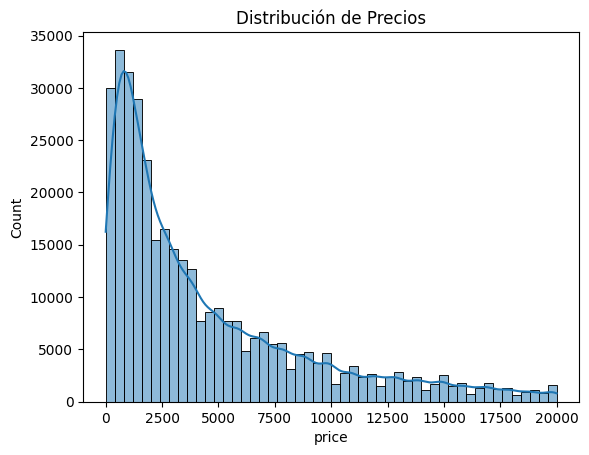

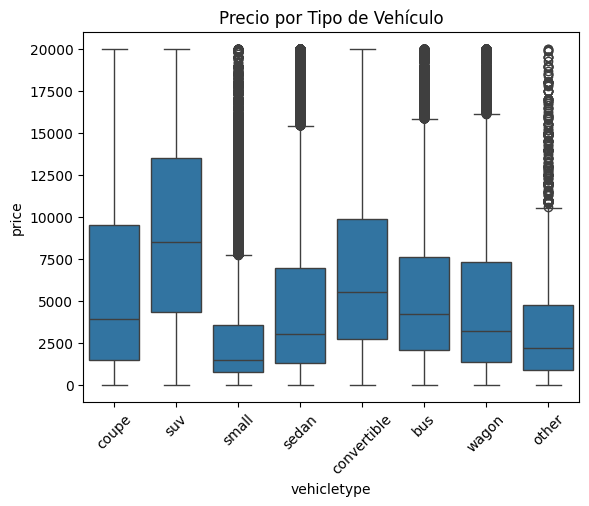

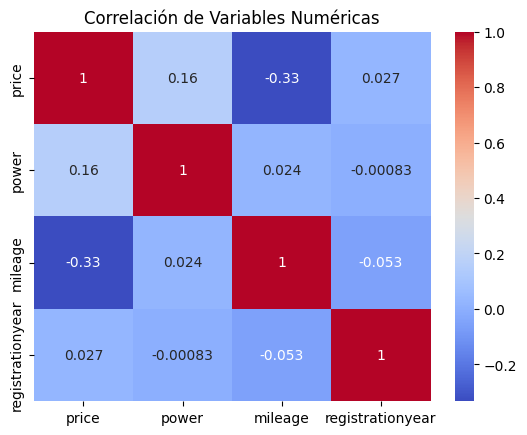

In [11]:
#Visualizamos datos
# Histograma de precios
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Distribución de Precios")
plt.show()

# Boxplot por tipo de vehículo
sns.boxplot(x='vehicletype', y='price', data=df)
plt.xticks(rotation=45)
plt.title("Precio por Tipo de Vehículo")
plt.show()

# Heatmap de correlaciones
numeric_cols = ['price', 'power', 'mileage', 'registrationyear']
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlación de Variables Numéricas")
plt.show()

,price,registrationyear,power,mileage
price,1.000000,0.026916,0.158872,-0.333199
registrationyear,0.026916,1.000000,-0.000828,-0.053447
power,0.158872,-0.000828,1.000000,0.024002
mileage,-0.333199,-0.053447,0.024002,1.000000


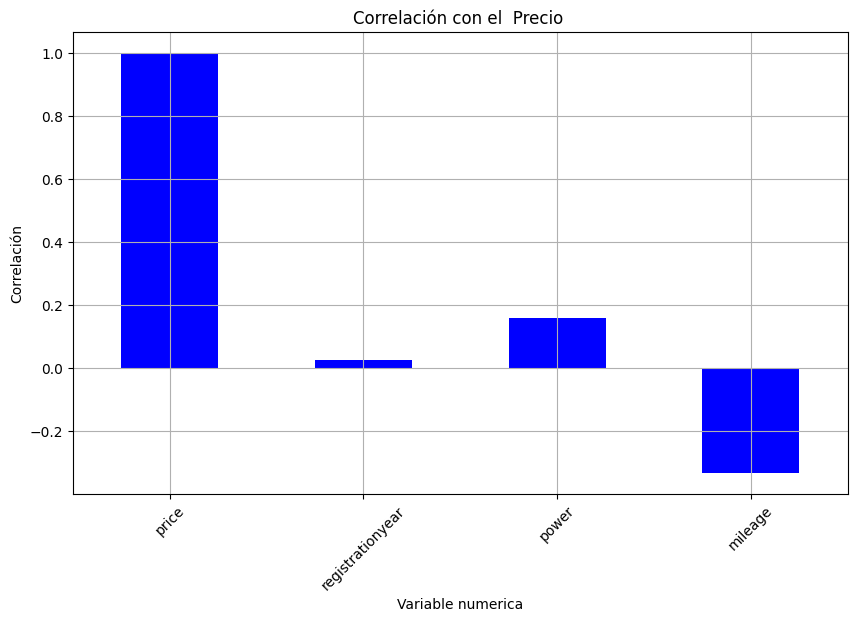

In [12]:
numeric=df.select_dtypes(include=['int64']).columns
df[numeric].corr()["price"].plot(kind="bar",
                     figsize=(10, 6), 
                     color='blue',                     
                     title='Correlación con el  Precio ', 
                     xlabel='Variable numerica', 
                     ylabel='Correlación',
                     rot=45,
                     grid= True)
df[df.select_dtypes(include=['int64']).columns].corr()

__OBSERVACIONES:__

- Se tienen valores nulos entre el 5% y 20% de los registros en 5 registros por lo que se tienen que trabajar dichos valores para tener bases completas y realizar el entrenamiento del modelo.
- Existen columnas sin relevancia por lo que se eliminan
- Se homologo el tipo de combustible ya que pretol y gasolina correspondian al mismo concepto
- Se convierte a una variable binaria la columna notrepaired para el correcto entrenamiento del modelo y se llena con Nan
- Tenemos correlación positiva muy baja entre potencia y precio, adicional correlación negativa mas alta entre precio y kilometros recorridos


In [13]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             354369 non-null  int64 
 1   vehicletype       316879 non-null  object
 2   registrationyear  354369 non-null  int64 
 3   gearbox           334536 non-null  object
 4   power             354369 non-null  int64 
 5   model             334664 non-null  object
 6   mileage           354369 non-null  int64 
 7   fueltype          321474 non-null  object
 8   brand             354369 non-null  object
 9   notrepaired       354369 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


,price,registrationyear,power,mileage
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Se observa información en precio y potencia en 0 y el año de registro con valores menores a 1900 por lo que revisamos dicha información

In [14]:

print("Elementos con precio igual a cero:",df[df["price"]==0]["price"].count())
print("Elementos con potencia igual a cero:",df[df["power"]==0]["power"].count())
print("Elementos con un año superior al  actual:",df[df["registrationyear"]>2024]["registrationyear"].count())
print("Elementos con un año inferior a 1900:",df[df["registrationyear"]<1900]["registrationyear"].count())

Elementos con precio igual a cero: 10772
Elementos con potencia igual a cero: 40225
Elementos con un año superior al  actual: 105
Elementos con un año inferior a 1900: 66


__TRABAJAMOS EL PRECIO__

,vehicletype,registrationyear,gearbox,power,model,mileage,fueltype,brand,notrepaired
price,,,,,,,,,
0,7032,10772,8294,10772,8588,10772,7336,10772,10772
1,721,1189,818,1189,936,1189,749,1189,1189
2,8,12,9,12,10,12,10,12,12
3,5,8,5,8,5,8,5,8,8
4,0,1,0,1,0,1,0,1,1
5,15,26,13,26,21,26,10,26,26
7,1,3,1,3,2,3,2,3,3
8,0,9,0,9,1,9,0,9,9
9,5,8,5,8,6,8,5,8,8


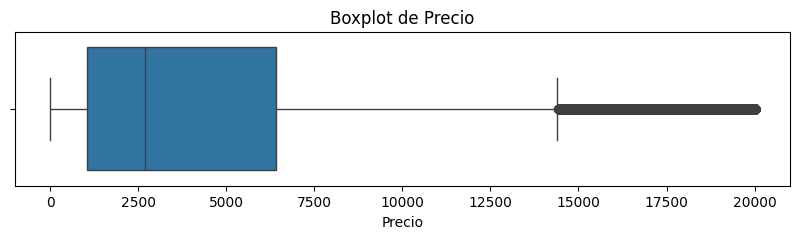

In [15]:
# Veremos la distribución del precio
display(df.groupby("price").count().head(10))

# Graficamos boxplot de precio
plt.figure(figsize=(10, 2))
sns.boxplot(x=df["price"])
plt.title("Boxplot de Precio")
plt.xlabel("Precio")
plt.show()

In [16]:
# Considerando el precio promedio mas bajo del mercado es de 300 euros, imputaremos con KNN los valores menores a 300
df.loc[df["price"]<300,"price"]=np.nan
numeric=df.select_dtypes(include=['int64','float64']).columns
imputer = KNNImputer(missing_values=np.nan, n_neighbors=2, copy=False)
imputer.fit_transform(df[numeric])

array([[4.800e+02, 1.993e+03, 0.000e+00, 1.500e+05],
       [1.830e+04, 2.011e+03, 1.900e+02, 1.250e+05],
       [9.800e+03, 2.004e+03, 1.630e+02, 1.250e+05],
       ...,
       [1.199e+03, 2.000e+03, 1.010e+02, 1.250e+05],
       [9.200e+03, 1.996e+03, 1.020e+02, 1.500e+05],
       [3.400e+03, 2.002e+03, 1.000e+02, 1.500e+05]], shape=(354369, 4))

In [17]:
# Eliminamos outliers de precio
bigote_superior = df['price'].quantile(0.75) + (1.5 * (df['price'].quantile(0.75) - df['price'].quantile(0.25)))
df = df[df['price'] < bigote_superior].reset_index(drop=True)
bigote_superior

np.float64(15025.0)

,vehicletype,registrationyear,gearbox,power,model,mileage,fueltype,brand,notrepaired
price,,,,,,,,,
300.0,2091,2731,2392,2731,2438,2731,2139,2731,2731
301.0,4,4,4,4,4,4,4,4,4
305.0,1,1,1,1,1,1,1,1,1
308.0,1,1,1,1,1,1,1,1,1
309.0,2,2,1,2,2,2,2,2,2
310.0,7,10,9,10,10,10,9,10,10
315.0,2,3,3,3,3,3,2,3,3
316.0,1,1,1,1,1,1,1,1,1
319.0,1,1,1,1,1,1,1,1,1


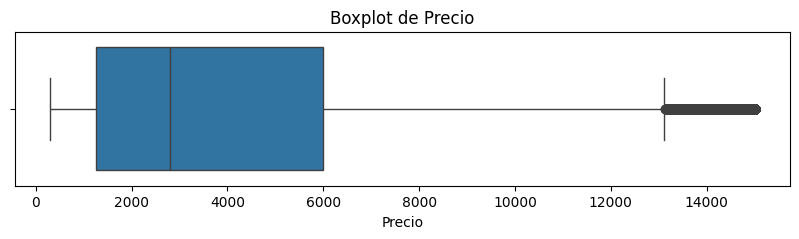

In [18]:
# Revisamos la nueva distribucion de precios
display(df.groupby("price").count().head(10))

plt.figure(figsize=(10, 2))
sns.boxplot(x=df["price"])
plt.title("Boxplot de Precio")
plt.xlabel("Precio")
plt.show()

__TRABAJAMOS EL AÑO__

,price,vehicletype,gearbox,power,model,mileage,fueltype,brand,notrepaired
registrationyear,,,,,,,,,
1000,19,0,2,19,8,19,4,19,19
1001,1,0,0,1,1,1,0,1,1
1039,1,0,0,1,0,1,1,1,1
1111,1,0,0,1,0,1,0,1,1
1234,2,0,0,2,0,2,0,2,2
1300,1,0,0,1,1,1,0,1,1
1400,1,0,1,1,1,1,1,1,1
1500,2,0,2,2,1,2,0,2,2
1600,2,0,1,2,1,2,1,2,2


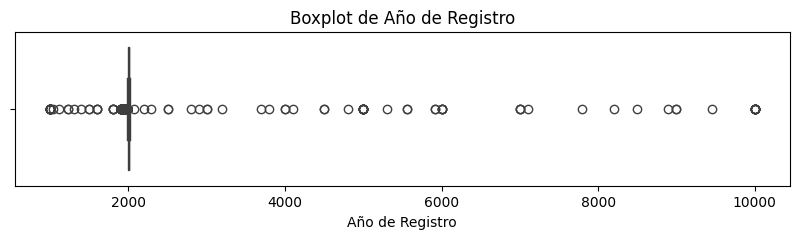

In [19]:
# Veremos la distribución del precio
display(df.groupby("registrationyear").count().head(10))

# Graficamos boxplot de precio
plt.figure(figsize=(10, 2))
sns.boxplot(x=df["registrationyear"])
plt.title("Boxplot de Año de Registro")
plt.xlabel("Año de Registro")
plt.show()

In [20]:
# Tenemos valores de año de registro superiores al año actual y registros anteriores a 1900
# Reemplazamos los valores con la media oara no afectar la distribucion de los datos
df.loc[df["registrationyear"] >2025 , "registrationyear"] =df[df["registrationyear"]!=0]["registrationyear"].median()
df.loc[df["registrationyear"] <1900, "registrationyear"] =df[df["registrationyear"]!=0]["registrationyear"].median()

print(df["registrationyear"].unique())
df[df["registrationyear"]!=0]["registrationyear"].median()

[1993 2004 2001 2008 1995 2014 1998 2005 1910 2016 2007 2009 2002 2018
 1997 1990 2017 1981 2003 1991 1984 2006 1999 2012 2010 2000 1992 2013
 1994 1996 1989 2011 1985 1982 1976 1973 2015 1969 1971 1987 1983 1988
 1980 1970 1986 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977 1961
 1966 1975 1963 1964 1958 1967 1960 1941 1962 1929 1957 1940 1949 2019
 1937 1951 1959 1954 1953 1952 1950 1942 1956 1935 1936 1923 1930 1944
 1938 1934 1943 1928 1932 1931 1948 1946]


np.float64(2003.0)

,price,vehicletype,gearbox,power,model,mileage,fueltype,brand,notrepaired
registrationyear,,,,,,,,,
1910,22,6,8,22,11,22,7,22,22
1923,2,2,2,2,2,2,2,2,2
1925,1,1,0,1,0,1,0,1,1
1928,2,2,1,2,2,2,1,2,2
1929,4,4,3,4,2,4,3,4,4
1930,1,1,1,1,1,1,1,1,1
1931,1,1,1,1,1,1,1,1,1
1932,2,2,1,2,2,2,1,2,2
1934,2,2,1,2,1,2,2,2,2


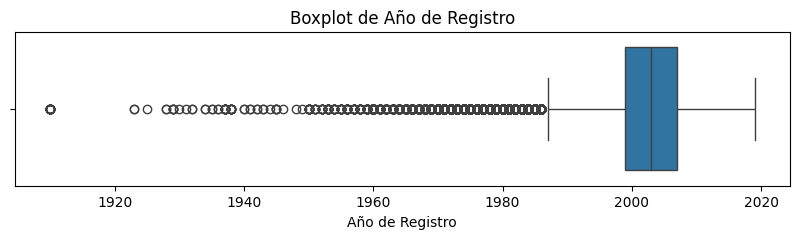

In [21]:
# Revisamos la nueva distribucion de potencia
display(df.groupby("registrationyear").count().head(10))

plt.figure(figsize=(10, 2))
sns.boxplot(x=df["registrationyear"])
plt.title("Boxplot de Año de Registro")
plt.xlabel("Año de Registro")
plt.show()

__TRABAJAMOS LA POTENCIA__

,price,vehicletype,registrationyear,gearbox,model,mileage,fueltype,brand,notrepaired
power,,,,,,,,,
0,31535,21612,31535,22511,27405,31535,24084,31535,31535
1,20,17,20,17,16,20,15,20,20
2,9,8,9,8,4,9,8,9,9
3,9,8,9,9,1,9,8,9,9
4,28,25,28,28,4,28,25,28,28
5,98,91,98,94,13,98,92,98,98
6,10,10,10,10,3,10,7,10,10
7,10,10,10,9,3,10,10,10,10
8,7,6,7,6,5,7,6,7,7


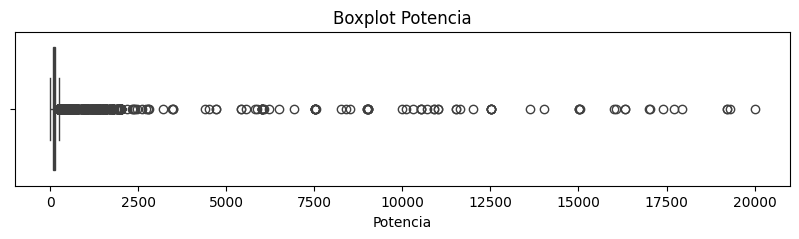

In [22]:
# Veremos la distribución del precio
display(df.groupby("power").count().head(10))

# Graficamos boxplot de precio
plt.figure(figsize=(10, 2))
sns.boxplot(x=df["power"])
plt.title("Boxplot Potencia")
plt.xlabel("Potencia")
plt.show()

Existen demasiados datos con valores excesivamente menores y mayores por lo que haremos un modelo de regresión lineal que calcule los valores para las entradas con potencia cero, luego descartareamos las entradas con valores atipicamente pequeños y grandes.

In [23]:
features = df[['price', 'registrationyear', 'mileage']]
target = df['power']

# Dividir los datos en entrenamiento y prueba
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)

model = LinearRegression()
model.fit(features_train, target_train)

# Predecir los valores de Power para las entradas con valores cero
missing_power = df[df['power']==0]
predicted_power = model.predict(missing_power[['price', 'registrationyear', 'mileage']])

df.loc[df['power']==0, 'power'] = np.int64(predicted_power)

In [24]:
# Eliminamos outliers de potencia
Q1 = df['power'].quantile(0.25)
Q3 = df['power'].quantile(0.75)
IQR = Q3 - Q1

bigote_inferior = Q1 - 1.5 * IQR
bigote_superior= Q1 + 1.5 * IQR

# Identificar valores atípicamente pequeños
df = df[df['power'] > bigote_inferior].reset_index(drop=True)
df = df[df['power'] < bigote_superior].reset_index(drop=True)

,price,vehicletype,registrationyear,gearbox,model,mileage,fueltype,brand,notrepaired
power,,,,,,,,,
1,20,17,20,17,16,20,15,20,20
2,9,8,9,8,4,9,8,9,9
3,9,8,9,9,1,9,8,9,9
4,28,25,28,28,4,28,25,28,28
5,98,91,98,94,13,98,92,98,98
6,12,10,12,12,5,12,9,12,12
7,22,10,22,16,13,22,20,22,22
8,35,7,35,17,23,35,14,35,35
9,32,3,32,15,24,32,15,32,32


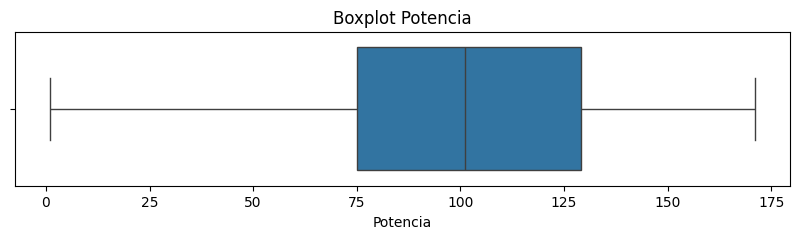

In [25]:
# Revisamos la nueva distribucion de potencia
display(df.groupby("power").count().head(10))

# Graficamos boxplot de precio
plt.figure(figsize=(10, 2))
sns.boxplot(x=df["power"])
plt.title("Boxplot Potencia")
plt.xlabel("Potencia")
plt.show()

__DATOS NULOS__

In [26]:
# Eliminamos datos nulos
df.dropna(how='all', inplace=True)
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280861 entries, 0 to 280860
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   price             280861 non-null  float64
 1   vehicletype       253174 non-null  object 
 2   registrationyear  280861 non-null  int64  
 3   gearbox           266955 non-null  object 
 4   power             280861 non-null  int64  
 5   model             267088 non-null  object 
 6   mileage           280861 non-null  int64  
 7   fueltype          257472 non-null  object 
 8   brand             280861 non-null  object 
 9   notrepaired       280861 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 21.4+ MB


,price,registrationyear,power,mileage
count,280861.000000,280861.000000,280861.000000,280861.000000
mean,3680.148369,2003.064356,103.163914,129068.257964
std,3329.491185,7.201691,33.431960,36492.511829
min,300.000000,1910.000000,1.000000,5000.000000
25%,1199.000000,1999.000000,75.000000,125000.000000
50%,2500.000000,2003.000000,101.000000,150000.000000
75%,5200.000000,2007.000000,129.000000,150000.000000
max,15001.000000,2019.000000,171.000000,150000.000000


In [27]:
df.isnull().mean()

price               0.000000
vehicletype         0.098579
registrationyear    0.000000
gearbox             0.049512
power               0.000000
model               0.049038
mileage             0.000000
fueltype            0.083276
brand               0.000000
notrepaired         0.000000
dtype: float64

In [28]:
# Rellenamos valores nulos con Nan para poder entrenar el modelo
df.fillna(value='NaN', inplace=True)
df.isnull().mean()

price               0.0
vehicletype         0.0
registrationyear    0.0
gearbox             0.0
power               0.0
model               0.0
mileage             0.0
fueltype            0.0
brand               0.0
notrepaired         0.0
dtype: float64

In [29]:
# Aplicaremos OHE para poder utilizar el modelos de regresion lineal y arboles aleatorio de decision
df_ohe=(pd.get_dummies(df,drop_first=True))
df_ohe.head()

,price,registrationyear,power,mileage,vehicletype_bus,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_1,notrepaired_NaN
0,480.0,1993,93,150000,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
1,9800.0,2004,163,125000,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,1500.0,2001,75,150000,False,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
3,3600.0,2008,69,90000,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,650.0,1995,102,150000,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False


Dataset Normal

In [30]:
features = df.drop("price",axis=1)
target = df["price"]

features_train, features_valid, target_train, target_valid = train_test_split(features, target, random_state=12345, test_size =0.75) 

Dataset con one hot encoding:


In [31]:
# Dividimos los datos en entrenamiento y validacion
features = df_ohe.drop("price",axis=1)
target = df_ohe["price"]

features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features, 
                        target, 
                        random_state=12345, 
                        test_size =0.75) 

__ESCALADO CARACTERISTICAS__

In [32]:
numeric = features_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric]=scaler.transform(features_train[numeric])
features_valid[numeric]=scaler.transform(features_valid[numeric])

scaler2 = StandardScaler()
scaler2.fit(features_train_ohe[numeric])
features_train_ohe[numeric]=scaler2.transform(features_train_ohe[numeric])
features_valid_ohe[numeric]=scaler2.transform(features_valid_ohe[numeric])

## Entrenamiento del modelo 

Debido a que nuestro objetivo es cuantitativo, ocuparemos modelos de regresión tales como Bosque aleatorio de regresión, árbol aleatorio de regresión, regresión lineal y metodos de potenciación de gradiente, entrenaremos los modelos en dicho orden.

### __BOSQUE DE DESICION DE REGRESION:__

Primero usaremos este bosque para crear un analisis de importancia de caracteristicas; por esto mismo no aplicaremos cross validation, pues ahora mismo no nos importa tanto la precisión del error, si no las caracteristicas que componen el modelo, a la vez iteraremos a través de multiples parametros para encontrar un aproximado de hiperparametros.

In [33]:
param_grid = {
    'n_estimators': range(10, 71, 10),
    'max_depth': range(1, 11)
}
model = RandomForestRegressor(random_state=54321)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=4, scoring='neg_root_mean_squared_error', n_jobs=-1)

start_time = time.time()

grid_search.fit(features_train_ohe, target_train_ohe)

best_params = grid_search.best_params_
best_error = -grid_search.best_score_
error_forest=best_error

forest_time = time.time() - start_time

print("\nRECM del mejor modelo en el conjunto de validación:", best_error)
print("Hiperparámetros:\n- n_estimators:", best_params['n_estimators'], "\n- max_depth:", best_params['max_depth'])
print("Tiempo de ejecución:", forest_time, "segundos")


RECM del mejor modelo en el conjunto de validación: 1460.7590746167193
Hiperparámetros:
- n_estimators: 70 
- max_depth: 10
Tiempo de ejecución: 1008.0356540679932 segundos


__*Analisis de Importancia de Caracteristicas*__

In [34]:
# Revisamos la importancia de las variables
best_model = RandomForestRegressor(random_state=54321, 
                n_estimators=best_params['n_estimators'], 
                max_depth=best_params['max_depth'])
                
best_model.fit(features_train_ohe, target_train_ohe)

RandomForestRegressor(max_depth=10, n_estimators=70, random_state=54321)

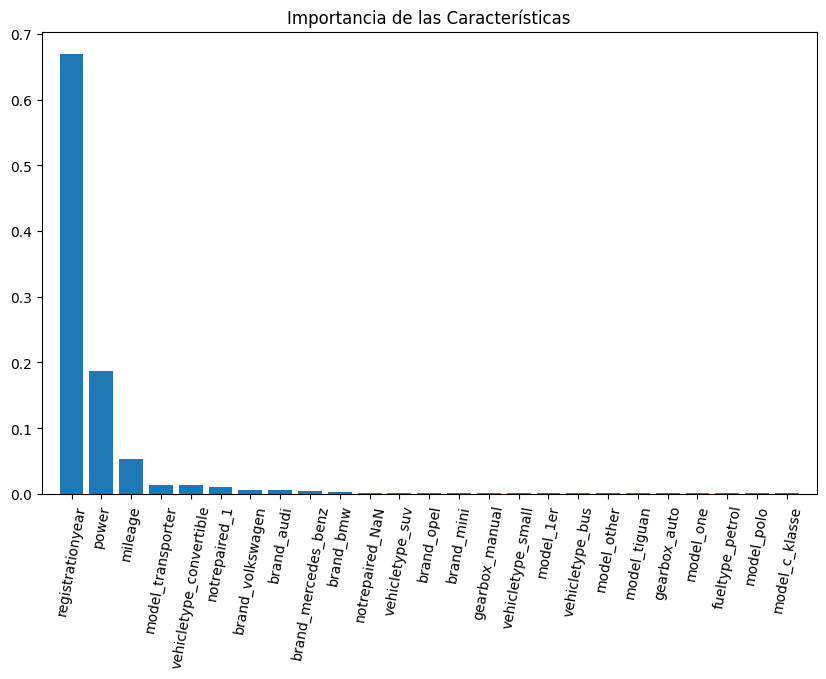

In [35]:
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

feature_names = features_train_ohe.columns

n=25
plt.figure(figsize=(10, 6))

plt.title("Importancia de las Características")


plt.bar(range(n), importances[indices[:n]])
plt.xticks(range(n), feature_names[indices[:n]], rotation=80)
plt.xlim([-1, n])
plt.show()

__OBSERVACIONES:__
- Vemos que las variables mas importantes para predecir el target son el año de registro, potencia y kilometraje
- La variable brand tiene cierta relevancia por lo que podriamos agruparla para eliminar el número de variabbles
- Las variables model, gearbox y fueltype no tienen cierta relevancia por lo que podemos proceder a eliminarlas

brand
mini              7543.125836
jeep              6131.391892
land_rover        5928.334375
dacia             5795.371429
porsche           5678.352941
skoda             5360.059061
jaguar            4774.153846
chevrolet         4672.123743
audi              4651.810385
hyundai           4650.516833
bmw               4433.380870
kia               4398.489242
mercedes_benz     4380.342931
toyota            4299.030561
sonstige_autos    4257.488816
suzuki            3976.357712
volkswagen        3916.713107
seat              3735.344657
nissan            3514.429810
smart             3510.636417
citroen           3492.034069
honda             3456.221328
mazda             3379.197963
alfa_romeo        3287.820739
lada              3280.903846
volvo             3160.034904
peugeot           3067.760602
ford              2942.523569
saab              2915.415698
subaru            2899.491071
fiat              2855.289116
mitsubishi        2811.746201
opel              2749.654551
chry

<Axes: xlabel='brand'>

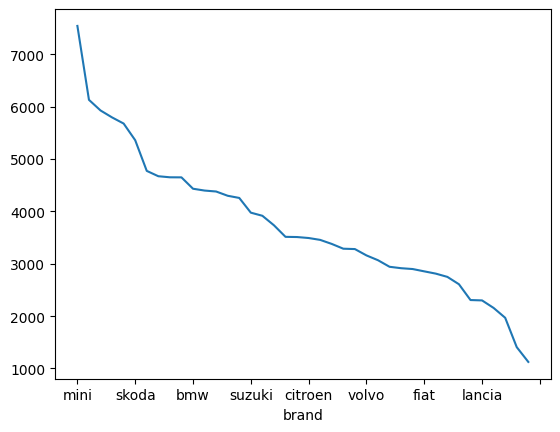

In [38]:
# Agrupamos la marca con respecto al precio para la agrupacion de los datos
display(df.groupby("brand")["price"].mean().sort_values(ascending=False))
df.groupby("brand")["price"].mean().sort_values(ascending=False).plot()

In [39]:
# Creamos una funcion para agrupar las marcas
def categorize_brand(price):
    luxury = 4500  
    high_price = 4000
    mid_price = 2000
    if price >= luxury:
        return 3
    elif price >= high_price:
        return 2
    elif price >= mid_price:
        return 1
    else:
        return 0

In [44]:
precio_marca = df.groupby("brand")["price"].mean()
brand_categories = precio_marca.apply(categorize_brand)

# Agregamos la categoria a cada dataframe
df['brand_Category'] = df['brand'].map(brand_categories).fillna('Unknown')
df_ohe['brand_Category'] = df['brand'].map(brand_categories).fillna('Unknown')

# Eliminamos caracteristicas que no aportan valor al modelo
df.drop(["brand","model","vehicletype","gearbox","fueltype"],axis=1,inplace=True)

In [48]:
df.head(3)

,price,registrationyear,power,mileage,notrepaired,brand_Category
0,480.0,1993,93,150000,NaN,1
1,9800.0,2004,163,125000,NaN,3
2,1500.0,2001,75,150000,0,1


In [52]:
# Reprocesamos el dataframe para entrenar el modelo
df_ohe=(pd.get_dummies(df,drop_first=True))

features = df_ohe.drop("price",axis=1)
target = df_ohe["price"]

features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features, 
                        target, 
                        random_state=12345, 
                        test_size =0.75)

scaler2 = StandardScaler()
scaler2.fit(features_train_ohe[numeric])
features_train_ohe[numeric]=scaler2.transform(features_train_ohe[numeric])
features_valid_ohe[numeric]=scaler2.transform(features_valid_ohe[numeric])

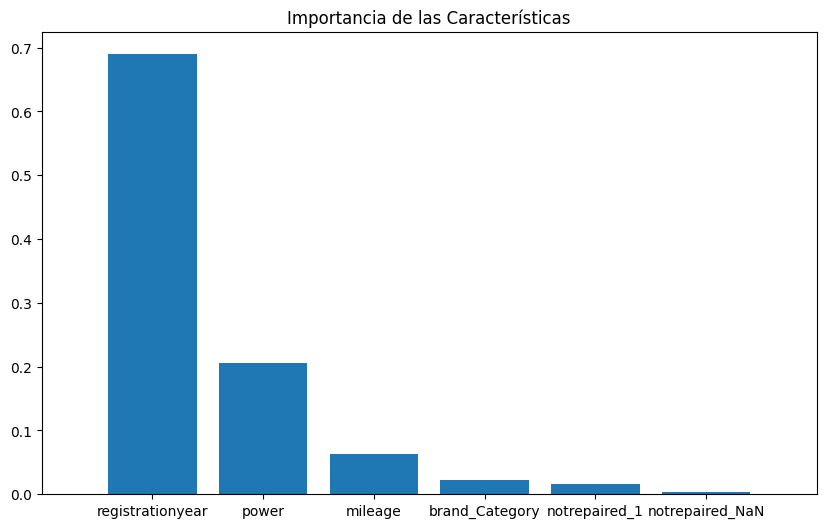

In [54]:
# Observamos como queda la importancia de las variables
best_model = RandomForestRegressor(random_state=54321, 
                n_estimators=best_params['n_estimators'], 
                max_depth=best_params['max_depth'])
                
best_model.fit(features_train_ohe, target_train_ohe)

importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

feature_names = features_train_ohe.columns

n=6
plt.figure(figsize=(10, 6))

plt.title("Importancia de las Características")


plt.bar(range(n), importances[indices[:n]])
plt.xticks(range(n), feature_names[indices[:n]], rotation=0)
plt.xlim([-1, n])
plt.show()

### __ARBOL DE DESICION DE REGRESION:__

In [55]:
%%time 
start_time = time.time()
model = DecisionTreeRegressor(random_state=12345)

param_grid = {
    'max_depth': range(7, 15)  
}

scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scorer,  
    cv=4,            
    verbose=0,
    n_jobs=-1       
)

grid_search.fit(features_train_ohe, target_train_ohe)

# Obtener los mejores parámetros y el mejor score
best_params = grid_search.best_params_
best_rmse = -grid_search.best_score_


end_time = time.time()
tree_time= end_time - start_time
error_tree=best_rmse
print(f"RECM del mejor modelo en el conjunto de validación: {best_rmse} \ncon una profundidad maxima de {best_params}")

RECM del mejor modelo en el conjunto de validación: 1629.1200490707224 
con una profundidad maxima de {'max_depth': 10}
CPU times: total: 609 ms
Wall time: 6.65 s


### __REGRESION LINEAL:__

In [57]:
%%time
start_time=time.time()
model = LinearRegression()
model.fit(features_train_ohe, target_train_ohe) 
predictions_valid_ohe = model.predict(features_valid_ohe) 

result_lineal =root_mean_squared_error(target_valid_ohe,predictions_valid_ohe)
print("RECM del modelo de regresión lineal en el conjunto de validación:", result_lineal)
error_regresion=result_lineal
end_time = time.time()
regresión_time= end_time - start_time

RECM del modelo de regresión lineal en el conjunto de validación: 2372.246537477242
CPU times: total: 172 ms
Wall time: 49.5 ms


- Aplicaremos regresión lineal con Ridge y Lasso

In [58]:
#  Ridge
start_time=time.time()

model_ridge = Ridge(alpha=2.0)
model_ridge.fit(features_train_ohe, target_train_ohe)
predictions_valid_ohe_ridge = model_ridge.predict(features_valid_ohe)

result_ridge = root_mean_squared_error(target_valid_ohe, predictions_valid_ohe_ridge)
print("RECM del modelo de regresión lineal usando Ridge en el conjunto de validación:", result_ridge)
error_ridge=result_ridge
end_time = time.time()
ridge_time= end_time - start_time

RECM del modelo de regresión lineal usando Ridge en el conjunto de validación: 2372.246185434795


In [59]:
# Lasso
start_time=time.time()

model_lasso = Lasso(alpha=0.2)
model_lasso.fit(features_train_ohe, target_train_ohe)
predictions_valid_ohe_lasso = model_lasso.predict(features_valid_ohe)

result_lasso = root_mean_squared_error(target_valid_ohe, predictions_valid_ohe_lasso)
print("RECM del modelo de regresión lineal usando Lasso en el conjunto de validación:", result_lasso)
error_Lasso=result_ridge
end_time = time.time()
lasso_time= end_time - start_time

RECM del modelo de regresión lineal usando Lasso en el conjunto de validación: 2372.2454798081103


- El modelo de Regresión Lineal no sufre un sobreajuste por eso vemos variaciones minimas entre cada regresión aplicada.

### __CATBOOST: POTENCIACION DEL GRADIANTE (ARBOL DE DESICION)__
- Maneja carácterisiticas categóricas sin preprocesar con *OHE*
- Diseñado para ser eficiente en términos de velocidad de entrenamiento y predicción
- Proporciona herramientas para visualizar métricas de entrenamiento, importancia de las características y la estructura de los árboles
- Es necesario indicar las variables categoricas


In [60]:
categorias = features_train.select_dtypes(include=['object']).columns
print(categorias)
indices_categorias = [features_train.columns.get_loc(categoria) for categoria in categorias]
print("Índices de las columnas categóricas:", indices_categorias)

Index(['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired'], dtype='object')
Índices de las columnas categóricas: [0, 2, 4, 6, 7, 8]


In [66]:
%%time
model = CatBoostRegressor(random_seed=54321, learning_rate=0.1, loss_function='RMSE', verbose=0)

param_grid = {
    'iterations': range(50, 81, 10),
    'depth': range(5, 15)
}

scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scorer,  
    cv=4,            
    verbose=0,
    n_jobs=-1       
)

grid_search.fit(features_train, target_train, cat_features=indices_categorias)

best_params = grid_search.best_params_
best_rmse = -grid_search.best_score_
error_catboost=best_rmse

print(f"Mejores parámetros: {best_params}")
print(f"Mejor RMSE en validación cruzada: {best_rmse}")

Mejores parámetros: {'depth': 14, 'iterations': 80}
Mejor RMSE en validación cruzada: 1306.1445580100385
CPU times: total: 1min 50s
Wall time: 11min 15s


### __LightGMB: POTENCIACION DEL GRADIANTE (ARBOL DE DESICION)__

- Crecimiento de árbol por hoja, es decir elige la hoja con mayor perdida para dividir
- Al igual que Catboost no es necesario aplicar *OHE*
- Aprovecha múltiples núcleos

LightGBM requiere definir sus datasets a través de "lgb.Dataset" indicandole que columnas son categoricas con:

```categorical_feature=indices_categorias```

y no liberando los dataframes 

```free_raw_data=False```

- Se tuvo que utilizar OHE debido a que mandaba error

In [69]:
train_data = lgb.Dataset(features_train_ohe, label=target_train, free_raw_data=False)
valid_data = lgb.Dataset(features_valid_ohe, label=target_valid, reference=train_data, free_raw_data=False)

In [70]:
%%time
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'verbose': 0
}
#num_leaves = max(2, 2**depth - 1)
num_leaves_values = [max(2,2**depth - 1) for depth in range(5, 16)]
n_estimators_values = range(50, 81, 10)

start_time = time.time()

best_error = 10000
best_params = None

for num_leaves in num_leaves_values:
    for n_estimators in n_estimators_values:
        params['num_leaves'] = num_leaves
        cv_results = lgb.cv(params, train_data, num_boost_round=n_estimators, 
                            nfold=4, metrics='rmse')
        #print("cv_results=",cv_results)
        mean_rmse = np.mean(cv_results["valid rmse-mean"])
        
        if mean_rmse < best_error:
            best_error = mean_rmse
            best_params = {
                'num_leaves': num_leaves,
                'n_estimators': n_estimators
            }

end_time = time.time()
lightGBM_time = end_time - start_time
error_lightGBM=best_error

print(f"\nRECM del mejor modelo en validación cruzada: {best_error}")
print(f"Mejores hiperparámetros -> n_estimators: {best_params['n_estimators']}, num_leaves: {best_params['num_leaves']}")

c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklear

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

### __XGBoost: POTENCIACION DEL GRADIANTE__

- Manejo eficiente de valores faltantes
- Poda ramas innecesarias para reducri sobreajuste
- Es necesario usar *OHE*

In [71]:
train_data = xgb.DMatrix(features_train_ohe, label=target_train_ohe)
valid_data = xgb.DMatrix(features_valid_ohe, label=target_valid_ohe)

In [72]:
%%time
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'tree_method': 'hist',
    'device': 'cuda'  # Usar GPU para el entrenamiento
}
# Definir el rango de hiperparámetro
max_depth_values = range(5, 16)
n_estimators_values = range(50, 81, 10)

best_error = float('inf')
best_params = {}

for depth in max_depth_values:
    for est in n_estimators_values:
        params['max_depth'] = depth
        cv_results = xgb.cv(
            params=params, 
            dtrain=train_data, 
            num_boost_round=est, 
            nfold=4, 
            early_stopping_rounds=10, 
            metrics='rmse', 
            seed=54321, 
            verbose_eval=False
        )
        
        mean_rmse = cv_results['test-rmse-mean'].min()
        
        if mean_rmse < best_error:
            best_error = mean_rmse
            best_params = {
                'n_estimators': est,
                'max_depth': depth
            }

end_time = time.time()
XGBoost_time = end_time - start_time
error_XGBoost=best_error
print(f"RECM del mejor modelo: {best_error} con los siguientes parámetros -> n_estimators: {best_params['n_estimators']}, max_depth: {best_params['max_depth']}")

c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:209: UserWarning: [16:46:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:49: No visible GPU is found, setting device to CPU.
  return getattr(self.bst, name)(*args, **kwargs)
c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:209: UserWarning: [16:46:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:203: XGBoost is not compiled with CUDA support.
  return getattr(self.bst, name)(*args, **kwargs)
c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:215: UserWarning: [16:46:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:49: No visible GPU is found, setting device to CPU.
  self.bst.update(self.dtrain, iteration, fobj)
c:\Users\AAFJ066661\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:215: UserWarning: [16:46:02] 

RECM del mejor modelo: 1502.483462682346 con los siguientes parámetros -> n_estimators: 80, max_depth: 9
CPU times: total: 8min 20s
Wall time: 1min 25s


## Análisis del modelo

Generamos un resumen del error de los modelos y tiempo de ejecución

In [84]:
df_modelos = pd.DataFrame({
    'Modelo': ['Bosque_de_decisión','Arbol_de_decisión', 'regresion_lineal', "regresión_lasso", "regresión_ridge","catboost","lightGBM","XGBoost"],
    'Error': [error_forest, error_tree, error_regresion,error_Lasso, error_ridge, error_catboost, error_lightGBM, error_XGBoost],
    'Tiempo de entrenamiento': [forest_time,tree_time,regresión_time, ridge_time, lasso_time,  catboost_time, lightGBM_time,XGBoost_time]
})

df_modelos

,Modelo,Error,Tiempo de entrenamiento
0,Bosque_de_decisión,1460.759075,1008.035654
1,Arbol_de_decisión,1629.120049,6.648584
2,regresion_lineal,2372.246537,0.049509
3,regresión_lasso,2372.246185,0.053976
4,regresión_ridge,2372.246185,0.040648
5,catboost,1306.144558,439.856334
6,lightGBM,1628.975854,362.734539
7,XGBoost,1502.483463,894.692669


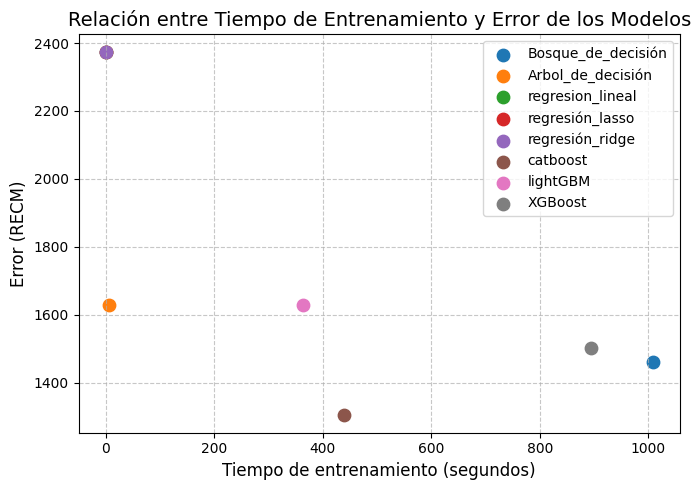

In [85]:
plt.figure(figsize=(7, 5)) 

for modelo in df_modelos['Modelo'].unique():  
    subset = df_modelos[df_modelos['Modelo'] == modelo]
    plt.scatter(subset['Tiempo de entrenamiento'], subset['Error'],
                label=modelo, s=80) 

plt.title('Relación entre Tiempo de Entrenamiento y Error de los Modelos', fontsize=14)
plt.xlabel('Tiempo de entrenamiento (segundos)', fontsize=12)
plt.ylabel('Error (RECM)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10, loc='upper right')  

plt.tight_layout()  
plt.show()

De nuestro grafico podemos nver lo siguiente:
- Todos los modelos tienen un error menor a la regresión lineal, lo cual sirve como **prueba de cordura** para todos los modelos.
- Todos los modelos tienen un tiempo mucho menor al bosque decisión.

Proponemos que el mejor modelo es generado con "*Catboost*" con un error de:

$RECM=1306.14$


**Considerando las necesidades de  *Rusty Bargain*, proponemos el uso de *Catboost* para las predicciones de su aplicación, debido a su excelente balance de calidad de predicción y tiempo de entrenamiento.**

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter

- [x]  Jupyter Notebook está abierto
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en orden de ejecución
- [x]  Los datos han sido descargados y preparados
- [x]  Los modelos han sido entrenados
- [x]  Se realizó el análisis de velocidad y calidad de los modelos